In [1]:
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics

import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.simplefilter('ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

#### read csv files from kaggle 

In [3]:
df_gemini_price_d = pd.read_csv('datasets/kaggle/BTCUSD_day.csv')
df_gemini_price_1h = pd.read_csv('datasets/kaggle/BTCUSD_1hr.csv')

#### convert columns to datetime

In [4]:
df_gemini_price_d['Date'] = pd.to_datetime(df_gemini_price_d['Date'])
df_gemini_price_1h['Date'] = pd.to_datetime(df_gemini_price_1h['Date'])

#### verify the range of datetime in dataframes

In [5]:
print('------------', 'df_gemini_price_d', '------------')
print(df_gemini_price_d['Date'].max())
print(df_gemini_price_d['Date'].min())
print('------------', 'df_gemini_price_1h', '------------')
print(df_gemini_price_1h['Date'].max())
print(df_gemini_price_1h['Date'].min())

------------ df_gemini_price_d ------------
2020-04-09 00:00:00
2015-10-08 00:00:00
------------ df_gemini_price_1h ------------
2020-04-09 00:00:00
2015-10-08 13:00:00


#### verify the numbers of lines in dataframes

In [6]:
print('------------', 'df_coinmarket_price_d', '------------')
print(df_gemini_price_d.shape[0])
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_gemini_price_1h.shape[0])

------------ df_coinmarket_price_d ------------
1646
------------ df_coinmarket_price_1h ------------
39468


In [7]:
class ProphetForecast(object):
    
    def __init__(self, df, percentage_train_size, periodicity):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
        self.periodicity = periodicity 
        
    def perform(self):
        
        best_params, train_size, y_train_predict = self.grid_search_model()
                
        array_pred = np.array([])
        
        date_test = self.df[train_size:]['Date'].values
        count = 0
        
        for current_datetime in date_test:

            pred = self.prediction(best_params = best_params, current_datetime = current_datetime)
            array_pred = np.append(array_pred, pred)
#             print('current_datetime ->', current_datetime)
#             print('pred ->', pred)
#             print('---')
            count += 1
            print(count/len(date_test)*100)
        print('---')

        date_train = self.df[:train_size]['Date'].values
#         date_train = y_train_predict.index
        y_train = self.df[:train_size]['Close'].values
        
        y_test = self.df[train_size:]['Close'].values
        
        data_train = {
          'date_train': date_train,
          'y_train': y_train,
#           'y_train_predict': y_train_predict.values
        }

        data_test = {
            'date_test': date_test,
            'y_test': y_test,
            'y_test_predict': array_pred
        }

        df_train = pd.DataFrame(data_train)
        df_test = pd.DataFrame(data_test)

        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_test['y_test'],
                                                                        df_test['y_test_predict'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)

        
        return df_train, df_test
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        try:
            corr, _ = pearsonr(y_truth, y_forecasted)
            pearson = round(corr, 4)
        except:
            pearson = None

        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_params, current_datetime):
        
        diff = best_params['diff_order']

        if self.periodicity == '1_day':
            train_datetime = (current_datetime - pd.Timedelta(days = 1))

        if self.periodicity == '1_hour':
            train_datetime = (current_datetime - pd.Timedelta(hours = 1))
        
        train_size = len(self.df[ self.df['Date'] <= train_datetime])
        df_train = self.prepare_data(diff, train_size)
        
        model = Prophet()
        fit_model = model.fit(df_train)
        
        if self.periodicity == '1_day':
            future = model.make_future_dataframe(periods=1, freq='D')
        if self.periodicity == '1_hour':
            future = model.make_future_dataframe(periods=1, freq='H')
            
        forecast = model.predict(future)
        pred = forecast.iloc[-1]['yhat']
        
#         print('forecast->\n', forecast.iloc[-1][['ds', 'yhat']])
#         pred = fit_model.predict(start = current_datetime, end = current_datetime)
#         print('train_size ->', train_size)    
#         print('train_datetime ->', train_datetime)
#         print('self.df[:train_size] ->', self.df[:train_size]['Date'].values[-1])
        
        #integration
        if diff == 1:
            
            last_close_price = self.df[:train_size]['Close'].values[-1]
            pred = last_close_price + pred
            
        if diff == 2:
            
            last_close_price = self.df[:train_size]['Close'].values[-1]
            before_last_close_price = self.df[:train_size]['Close'].values[-2]
            last_close_diff_price = last_close_price - before_last_close_price
            pred = last_close_price + last_close_diff_price + pred
        
        return pred
    
    def prepare_data(self, diff, train_size):

        if diff == 0:
            data = {
                'ds': self.df[:train_size]['Date'].values,
                'y': self.df[:train_size]['Close'].values
            }

        if diff == 1:
            data = {
                'ds': self.df[:train_size]['Date'].values[1:],
                'y': self.df[:train_size]['Close'].diff().values[1:]
            }

        if diff == 2:
            data = {
                'ds': self.df[:train_size]['Date'].values[2:],
                'y': self.df[:train_size]['Close'].diff().diff().values[2:]
            }

        df_result = pd.DataFrame(data)
        
        return df_result
    
    def grid_search_model(self):
        
        train_size = int(len(self.df) * self.percentage_train_size)
        
        best_mse = np.inf 
        best_params = None
        best_fit = None

        diff_range = range(3)
        d_range = range(3) # [0,1,2]

        for diff in diff_range:
            
            df_train = self.prepare_data(diff, train_size)
                        
            try:
                model = Prophet()
                fit_model = model.fit(df_train)
                
                df_aux = fit_model.predict()
                mse = round(mean_squared_error(df_train['y'], df_aux['yhat']), 4)
                
                if mse < best_mse:

                    best_mse = mse
                    best_params = {'diff_order': diff}
                    best_fit = fit_model

            except: continue

        print('MSE', best_mse, 'best_params', best_params)
        
        y_train_predict = best_fit.predict()
        
        return best_params, train_size, y_train_predict

In [10]:
#variar os seguintes parametros:
#growth
#changepoints
#n_changepoints
#changepoint_prior_scale

In [9]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df = df.sort_values(by = ['Date']).reset_index(drop = True)
df = df.loc[:, ['Date', 'Close']]

prophet_forecast = ProphetForecast(df = df,
                         percentage_train_size = 0.80,
                         periodicity = '1_day'
                        )
df_train, df_test = prophet_forecast.perform()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE 82911.9921 best_params {'diff_order': 1}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.30303030303030304


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.6060606060606061


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.9090909090909091


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1.2121212121212122


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1.5151515151515151


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1.8181818181818181


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2.1212121212121215


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2.4242424242424243


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2.727272727272727


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3.0303030303030303


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3.3333333333333335


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3.6363636363636362


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3.939393939393939


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4.242424242424243


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4.545454545454546


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4.848484848484849


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5.151515151515151


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5.454545454545454


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5.757575757575758


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6.0606060606060606


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6.363636363636363


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6.666666666666667


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6.969696969696971


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7.2727272727272725


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7.575757575757576


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7.878787878787878


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


8.181818181818182


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


8.484848484848486


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


8.787878787878787


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


9.090909090909092


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


9.393939393939393


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


9.696969696969697


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10.303030303030303


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10.606060606060606


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10.909090909090908


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11.212121212121213


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11.515151515151516


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11.818181818181818


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


12.121212121212121


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


12.424242424242424


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


12.727272727272727


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


13.030303030303031


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


13.333333333333334


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


13.636363636363635


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


13.939393939393941


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14.242424242424242


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14.545454545454545


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14.84848484848485


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


15.151515151515152


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


15.454545454545453


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


15.757575757575756


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


16.060606060606062


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


16.363636363636363


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


16.666666666666664


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


16.969696969696972


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


17.272727272727273


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


17.575757575757574


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


17.87878787878788


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


18.181818181818183


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


18.484848484848484


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


18.787878787878785


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


19.090909090909093


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


19.393939393939394


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


19.696969696969695


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


20.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


20.303030303030305


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


20.606060606060606


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


20.909090909090907


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


21.21212121212121


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


21.515151515151516


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


21.818181818181817


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


22.12121212121212


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


22.424242424242426


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


22.727272727272727


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


23.03030303030303


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


23.333333333333332


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


23.636363636363637


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


23.939393939393938


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


24.242424242424242


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


24.545454545454547


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


24.848484848484848


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


25.151515151515152


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


25.454545454545453


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


25.757575757575758


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


26.060606060606062


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


26.36363636363636


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


26.666666666666668


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


26.969696969696972


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


27.27272727272727


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


27.575757575757574


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


27.878787878787882


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


28.18181818181818


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


28.484848484848484


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


28.78787878787879


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


29.09090909090909


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


29.393939393939394


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


29.6969696969697


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


30.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


30.303030303030305


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


30.606060606060602


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


30.909090909090907


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


31.212121212121215


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


31.515151515151512


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


31.818181818181817


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


32.121212121212125


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


32.42424242424242


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


32.72727272727273


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33.03030303030303


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33.33333333333333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33.63636363636363


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33.939393939393945


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


34.24242424242424


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


34.54545454545455


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


34.84848484848485


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


35.15151515151515


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


35.45454545454545


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


35.75757575757576


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


36.06060606060606


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


36.36363636363637


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


36.666666666666664


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


36.96969696969697


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


37.27272727272727


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


37.57575757575757


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


37.878787878787875


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


38.18181818181819


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


38.484848484848484


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


38.78787878787879


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


39.09090909090909


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


39.39393939393939


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


39.696969696969695


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


40.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


40.303030303030305


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


40.60606060606061


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


40.909090909090914


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


41.21212121212121


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


41.515151515151516


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


41.81818181818181


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


42.12121212121212


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


42.42424242424242


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


42.72727272727273


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


43.03030303030303


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


43.333333333333336


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


43.63636363636363


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


43.93939393939394


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


44.24242424242424


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


44.54545454545455


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


44.84848484848485


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


45.151515151515156


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


45.45454545454545


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


45.75757575757576


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


46.06060606060606


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


46.36363636363636


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


46.666666666666664


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


46.96969696969697


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


47.27272727272727


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


47.57575757575758


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


47.878787878787875


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


48.18181818181818


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


48.484848484848484


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


48.78787878787879


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


49.09090909090909


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


49.3939393939394


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


49.696969696969695


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


50.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


50.303030303030305


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


50.60606060606061


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


50.90909090909091


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


51.21212121212121


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


51.515151515151516


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


51.81818181818182


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


52.121212121212125


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


52.42424242424243


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


52.72727272727272


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


53.03030303030303


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


53.333333333333336


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


53.63636363636364


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


53.939393939393945


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


54.24242424242425


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


54.54545454545454


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


54.848484848484844


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


55.15151515151515


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


55.45454545454545


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


55.757575757575765


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


56.060606060606055


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


56.36363636363636


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


56.666666666666664


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


56.96969696969697


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


57.27272727272727


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


57.57575757575758


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


57.878787878787875


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


58.18181818181818


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


58.484848484848484


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


58.78787878787879


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


59.09090909090909


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


59.3939393939394


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


59.696969696969695


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


60.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


60.303030303030305


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


60.60606060606061


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


60.909090909090914


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


61.212121212121204


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


61.51515151515151


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


61.81818181818181


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


62.121212121212125


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


62.42424242424243


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


62.727272727272734


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


63.030303030303024


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


63.33333333333333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


63.63636363636363


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


63.93939393939394


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


64.24242424242425


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


64.54545454545455


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


64.84848484848484


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


65.15151515151516


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


65.45454545454545


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


65.75757575757576


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


66.06060606060606


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


66.36363636363637


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


66.66666666666666


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


66.96969696969697


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


67.27272727272727


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


67.57575757575758


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


67.87878787878789


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


68.18181818181817


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


68.48484848484848


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


68.78787878787878


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


69.0909090909091


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


69.39393939393939


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


69.6969696969697


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


70.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


70.3030303030303


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


70.60606060606061


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


70.9090909090909


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


71.21212121212122


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


71.51515151515152


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


71.81818181818181


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


72.12121212121212


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


72.42424242424242


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


72.72727272727273


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


73.03030303030303


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


73.33333333333333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


73.63636363636363


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


73.93939393939394


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


74.24242424242425


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


74.54545454545455


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


74.84848484848486


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


75.15151515151514


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


75.45454545454545


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


75.75757575757575


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


76.06060606060606


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


76.36363636363637


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


76.66666666666667


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


76.96969696969697


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


77.27272727272727


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


77.57575757575758


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


77.87878787878788


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


78.18181818181819


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


78.48484848484848


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


78.78787878787878


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


79.0909090909091


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


79.39393939393939


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


79.6969696969697


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


80.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


80.3030303030303


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


80.60606060606061


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


80.9090909090909


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


81.21212121212122


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


81.51515151515152


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


81.81818181818183


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


82.12121212121211


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


82.42424242424242


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


82.72727272727273


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


83.03030303030303


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


83.33333333333334


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


83.63636363636363


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


83.93939393939394


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


84.24242424242424


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


84.54545454545455


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


84.84848484848484


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


85.15151515151516


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


85.45454545454545


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


85.75757575757575


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


86.06060606060606


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


86.36363636363636


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


86.66666666666667


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


86.96969696969697


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


87.27272727272727


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


87.57575757575758


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


87.87878787878788


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


88.18181818181819


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


88.48484848484848


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


88.7878787878788


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


89.0909090909091


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


89.39393939393939


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


89.6969696969697


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


90.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


90.30303030303031


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


90.6060606060606


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


90.9090909090909


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


91.21212121212122


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


91.51515151515152


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


91.81818181818183


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


92.12121212121212


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


92.42424242424242


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


92.72727272727272


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


93.03030303030303


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


93.33333333333333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


93.63636363636364


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


93.93939393939394


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


94.24242424242424


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


94.54545454545455


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


94.84848484848484


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


95.15151515151516


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


95.45454545454545


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


95.75757575757575


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


96.06060606060606


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


96.36363636363636


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


96.66666666666667


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


96.96969696969697


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


97.27272727272728


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


97.57575757575758


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


97.87878787878788


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


98.18181818181819


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


98.48484848484848


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


98.7878787878788


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


99.0909090909091


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


99.39393939393939


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


99.69696969696969
100.0
---
mae 262.5853 mape 3.044 mse 164085.3051 rmse 405.0744 rmspe 5.3364 r2 0.9284 pearson 0.9645


In [12]:
# Prophet 1d
# MSE 82911.9921 best_params {'diff_order': 1}
# mae 262.5853 mape 3.044 mse 164085.3051 rmse 405.0744 rmspe 5.3364 r2 0.9284 pearson 0.9645

In [1]:
# Prophet 1h
# MSE 4436.8313 best_params {'diff_order': 1}
# mae 44.0078 mape 0.5062 mse 6895.6031 rmse 83.0398 rmspe 1.0089 r2 0.997 pearson 0.9985

In [10]:
# df_train.tail()
df_test.head()

# df_train.to_csv('train_prophet_1d.csv', sep = "\t", index = False)
df_test.to_csv('test_prophet_1d.csv', sep = "\t", index = False)
# pd.read_csv('train_prophet_1d.csv', sep = "\t")
pd.read_csv('test_prophet_1d.csv', sep = "\t")

# df_train.to_csv('train_prophet_1h.csv', sep = "\t", index = False)
# df_test.to_csv('test_prophet_1h.csv', sep = "\t", index = False)
# pd.read_csv('train_prophet_1h.csv', sep = "\t")
# pd.read_csv('test_prophet_1h.csv', sep = "\t")

date_test   y_test  y_test_predict
0    2019-05-16  7881.38     8203.458149
1    2019-05-17  7361.92     7891.301289
2    2019-05-18  7262.52     7370.148812
3    2019-05-19  8192.44     7226.839815
4    2019-05-20  8003.97     8197.923516
..          ...      ...             ...
325  2020-04-05  6775.21     6885.369745
326  2020-04-06  7336.96     6821.298825
327  2020-04-07  7201.81     7364.928015
328  2020-04-08  7369.60     7228.712502
329  2020-04-09  7315.25     7377.315831

[330 rows x 3 columns]

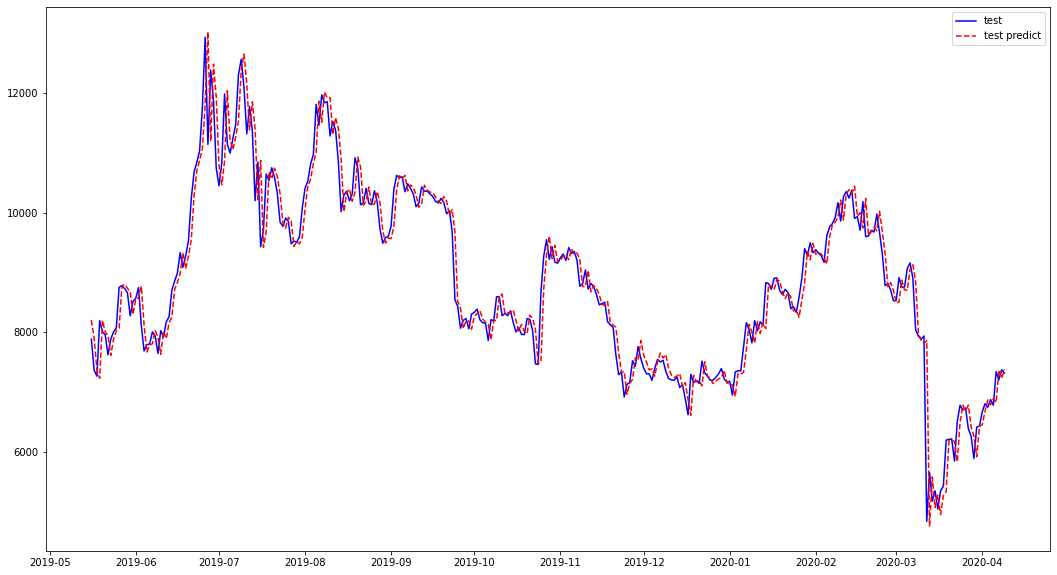

In [11]:
fig, ax = plt.subplots(figsize=(18, 10))

# ax.plot(df_train['date_train'], df_train['y_train'], label = 'train', color="blue")
# ax.plot(df_train['date_train'], df_train['y_train_predict'], '--', label = 'train predict', color="red")

ax.plot(df_test['date_test'], df_test['y_test'], label = 'test', color="blue")
ax.plot(df_test['date_test'], df_test['y_test_predict'], '--', label = 'test predict', color="red")

ax.legend()
plt.show()